<a href="https://colab.research.google.com/github/eric-shaker/BIOENG_1340_AUTO_TUMOR_SEGMENTATION/blob/main/Performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook displays the Dice Loss of the 3D U-Net model on the training set and the Dice Score and 3D IOU of the 3D U-Net model on the training and test set. The training set and test set are composed of the 64x64x64 images and masks.**

In [ ]:
#title Mount Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


#Install Packages

In [ ]:
#title Load the Prerequsite Libraries
!pip install SimpleITK
#!pip install itk

#!pip install 'simpleitk==2.0.0' --force-reinstall #previous library

import SimpleITK as sitk
import numpy as np
import os
import pandas as pd

#normalize function
def normalize (image):
    MIN_BOUND = np.min(image)
    MAX_BOUND = np.max(image)
    image = (image - MIN_BOUND).astype(float)/(MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 223 kB/s 


# Dice Score

In [ ]:
#@title Dice Score function
import scipy
from scipy.spatial import distance

def get_metrics(gt_folder, seg_folder, save_folder, save_file):
  if os.path.isdir(save_folder) == False:
    os.mkdir(save_folder)

  # Create DataFrame with GT files, extract the SEG-## from each one, and store this
  # subsequent string in a column called Extracted
  gt_list = pd.DataFrame(sorted(os.listdir(gt_folder)))
  gt_list.columns = ['GT']
  gt_list['Extracted'] = gt_list['GT'].apply(lambda x: int(x.split("_")[2]))
  gt_list = gt_list.sort_values(by=['Extracted'])

  
  # Create DataFrame with the automated files, extract the SEG-## from each one, and store this
  # subsequent string in a column called Extracted
  seg_list = pd.DataFrame(sorted(os.listdir(seg_folder)))
  seg_list.columns = ['Seg']
  seg_list = seg_list[seg_list['Seg'].str.find('.nii') != -1]
  seg_list.reset_index(drop=True,inplace=True)
  seg_list['Extracted'] = seg_list['Seg'].apply(lambda x: int(x.split("_")[3]))
  seg_list = seg_list.sort_values(by=['Extracted'])


  # Merge the DataFrames together on the Extracted column, and now each GT file should 
  # match with its respective automated file
  merged = gt_list.merge(seg_list, how='inner', on='Extracted')

  #ignore .npy files 
  gt_dir  = []
  seg_dir  = []
  for g, s in zip(merged['GT'], merged['Seg']):
    if g.endswith('.nii') | g.endswith('.nii.gz'):
      gt_dir.append(g)

    if s.endswith('.nii') | s.endswith('.nii.gz'):
      seg_dir.append(s)

  #iterate over the files
  metrics = []
  for i in range(len(gt_dir)):

    #read images
    gt = sitk.ReadImage(gt_folder + gt_dir[i])
    seg = sitk.ReadImage(seg_folder + seg_dir[i])

    # Convert the segmentation to a 8-bit unsigned integer
    seg = sitk.Cast(seg, sitk.sitkUInt8) 

    #get Dice Score
    dice = sitk.SimilarityIndexImageFilter() # establishes Dice Score
    dice.Execute(seg, gt)
    dice_score = dice.GetSimilarityIndex()

    #collect info
    metrics.append([gt_dir[i], seg_dir[i], True, dice_score])

  #visualize the data
  visualize = pd.DataFrame(metrics)
  if save_file.find('Test') != -1:
    visualize.columns =['Ground Truth', 'Prediction', 'Test', 'Dice Score']
  else:
    visualize.columns =['Ground Truth', 'Prediction', 'Training', 'Dice Score']

  #save file #remove the index
  visualize.to_csv(save_folder + save_file, index = False)
  #return the csv
  return visualize

In [ ]:
# Obtain the Dice Scores for all the training images
training_metrics = get_metrics("/content/gdrive/MyDrive/BIOENG_1340/BIOENG 1340 - Final Project/segs/train_segs_WT32/", # GT segmentation folder 
                           "/content/gdrive/MyDrive/BIOENG_1340/BIOENG 1340 - Final Project/code/models/Unet_Batch1_e50_TS_32/Unet_Seg_Batch1_Training_Binary_32/", # Model segmentation folder  
                           "/content/gdrive/MyDrive/BIOENG_1340/BIOENG 1340 - Final Project/code/models/Unet_Batch1_e50_TS_32/", # Parent folder
                           "Unet_Seg_Batch1_Training.csv")
display(training_metrics[["Training", "Dice Score"]].groupby(["Training"]).describe())

Dice Score                                                            \
              count      mean      std      min       25%       50%       75%   
Training                                                                        
True          100.0  0.898423  0.05058  0.71243  0.873776  0.906574  0.934876   

                 
            max  
Training         
True      0.976

In [ ]:
# Obtain the Dice Scores for all the test images
test_metrics = get_metrics("/content/gdrive/MyDrive/BIOENG_1340/BIOENG 1340 - Final Project/segs/test_segs_WT32/", 
                           "/content/gdrive/MyDrive/BIOENG_1340/BIOENG 1340 - Final Project/code/models/Unet_Batch1_e50_TS_32/Unet_Seg_Batch1_Test_Binary_32/",  
                           "/content/gdrive/MyDrive/BIOENG_1340/BIOENG 1340 - Final Project/code/models/Unet_Batch1_e50_TS_32/",
                           "Unet_Seg_Batch1_Test.csv")
display(test_metrics[["Test", "Dice Score"]].groupby(["Test"]).describe())

Dice Score                                                            \
          count      mean       std       min      25%       50%      75%   
Test                                                                        
True       49.0  0.736223  0.205594  0.051118  0.65534  0.817073  0.87309   

                
           max  
Test            
True  0.919668

U-Net Specifications: 
Learning Rate =  0.001
# of Epochs =  50
Mean Dice Score (Training) =  0.8984227798859874
Mean Dice Score (Test) =  0.7362232152455017
Median Dice Score (Training) =  0.9065739893130096
Median Dice Score (Test) =  0.8170731707317073


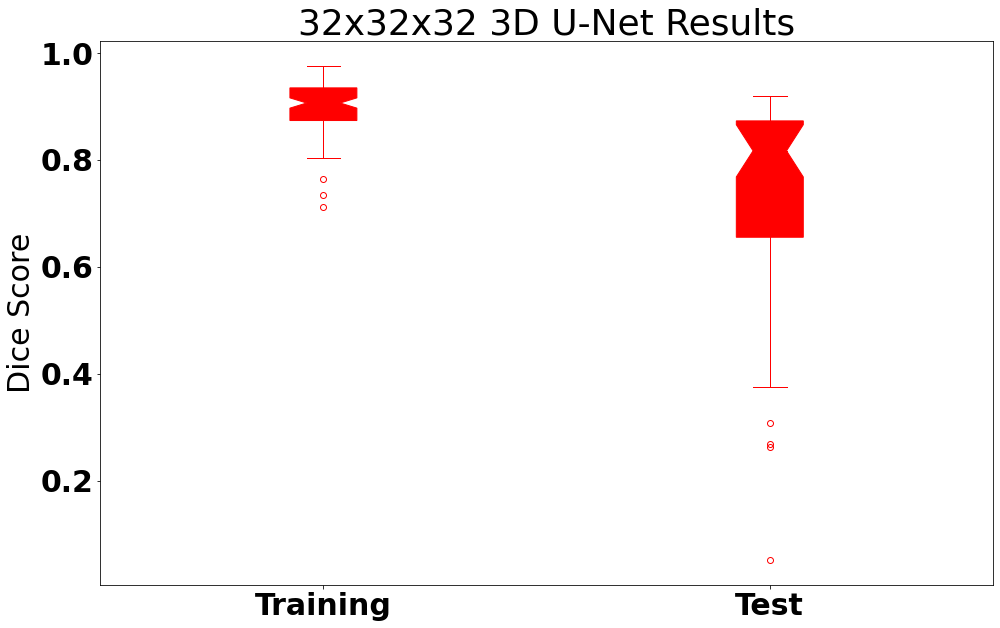

In [ ]:
# Plot boxplots of the training and test set Dice Score distributions
import matplotlib.pyplot as plt

learning_rate = 0.001
num_classes = 1
batch_size = 1
epochs = 50
DiceLoss = 'New'

print('U-Net Specifications: ')
print('Learning Rate = ', learning_rate)
print('# of Epochs = ', epochs)

train_dice_scores = np.array(list(training_metrics['Dice Score']))
test_dice_scores = np.array(list(test_metrics['Dice Score']))

print('Mean Dice Score (Training) = ', np.mean(train_dice_scores))
print('Mean Dice Score (Test) = ', np.mean(test_dice_scores))
print('Median Dice Score (Training) = ', np.median(train_dice_scores))
print('Median Dice Score (Test) = ', np.median(test_dice_scores))

c = "red"
fig, ax = plt.subplots(figsize = (16,10))
bp1 = plt.boxplot(np.array(train_dice_scores), positions = [1], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
bp2 = plt.boxplot(np.array(test_dice_scores), positions = [2], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
ax.set(xticks=[1,2], xticklabels=['Training','Test'])
plt.ylabel('Dice Score')
plt.title('32x32x32 3D U-Net Results')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

plt.rc('font', **font)
plt.show()